### paintype classification and visualisation

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

In [3]:
from compare_paintype import fit_bp, make_data_paintype
from compare_hyperparams import load_feats, feature_importance, load_modZ, load_cv
from compare_bfl_qsidp import load_qscode, match_question

/gpfs3/well/seymour/users/uhu195/python/extract-py3.7.4-skylake/lib/python3.7/site-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [4]:
import sklearn
print(sklearn.__version__)

0.24.2


In [5]:
import optuna
print(optuna.__version__)

2.9.1


### load cv results

In [6]:
curr_dir = '/well/seymour/users/uhu195/python/extract_npy'
cv_dir = os.path.join(curr_dir, 'cv_results', 'paintype')

In [7]:
df = load_cv(cv_dir).reset_index()

   max_depth  n_estimators  max_features  min_samples_split  min_samples_leaf  \
0          2           200      0.467359                 13                 1   
1          2           175      0.844838                 14                10   
2          6           175      0.610862                  6                13   
3         16           150      0.825022                 11                11   
4          2           200      0.620172                  6                 8   

   max_samples  balanced_accuracy   roc_auc  bestIC               qsidp  
0     0.972667           0.289195  0.552863     500                None  
1     0.800194           0.322034  0.568962     500          ['t1vols']  
2     0.879181           0.302966  0.567129     500  ['subcorticalvol']  
3     0.677255           0.313559  0.570047     500            ['fast']  
4     0.603097           0.304555  0.563455     500          ['t2star']  


In [12]:
np.unique(df['bestIC'])

array([  0,  30,  50, 100, 200, 500])

In [8]:
dfidp = load_cv(cv_dir, qtype='idp').reset_index()

   max_depth  n_estimators  max_features  min_samples_split  min_samples_leaf  \
0          2           200      0.467359                 13                 1   
1          2           175      0.844838                 14                10   
2          6           175      0.610862                  6                13   
3         16           150      0.825022                 11                11   
4          2           200      0.620172                  6                 8   

   max_samples  balanced_accuracy   roc_auc  bestIC               qsidp  
0     0.972667           0.289195  0.552863     500                None  
1     0.800194           0.322034  0.568962     500          ['t1vols']  
2     0.879181           0.302966  0.567129     500  ['subcorticalvol']  
3     0.677255           0.313559  0.570047     500            ['fast']  
4     0.603097           0.304555  0.563455     500          ['t2star']  


In [9]:
dfidp.iloc[dfidp['balanced_accuracy'].argsort()][-5:-1][['qsidp', 'bestIC', 'balanced_accuracy']]

,qsidp,bestIC,balanced_accuracy
253,"['t1vols', 'fast', 't2star', 'wdmri', 'taskfmri']",200,0.338983
75,"['t1vols', 'taskfmri']",30,0.339513
203,"['t1vols', 'taskfmri']",200,0.340042
122,"['t1vols', 'subcorticalvol', 'fast', 't2star',...",30,0.340042


In [10]:
df.iloc[df['balanced_accuracy'].argsort()][-5:-1][['qsidp', 'bestIC', 'balanced_accuracy']]

,qsidp,bestIC,balanced_accuracy
93,"['demographic', 'lifestyle', 't1vols', 'taskfm...",0,0.365466
87,"['demographic', 't1vols', 'taskfmri']",0,0.365466
283,"['cognitive', 'demographic', 'mental']",500,0.365996
122,"['cognitive', 'demographic', 'lifestyle']",200,0.372352


In [11]:
df.iloc[df['balanced_accuracy'].argmax()]

index                                                       11
max_depth                                                    4
n_estimators                                               125
max_features                                          0.603653
min_samples_split                                            8
min_samples_leaf                                            12
max_samples                                           0.741283
balanced_accuracy                                     0.372352
roc_auc                                               0.602889
bestIC                                                     200
qsidp                ['cognitive', 'demographic', 'lifestyle']
Name: 122, dtype: object

In [14]:
tmp = df[df['bestIC']==0]
tmp.iloc[tmp['balanced_accuracy'].argmax()]

index                                                      17
max_depth                                                   2
n_estimators                                              250
max_features                                         0.877968
min_samples_split                                           8
min_samples_leaf                                           14
max_samples                                          0.717079
balanced_accuracy                                    0.365466
roc_auc                                              0.604925
bestIC                                                      0
qsidp                ['cognitive', 'demographic', 'taskfmri']
Name: 81, dtype: object

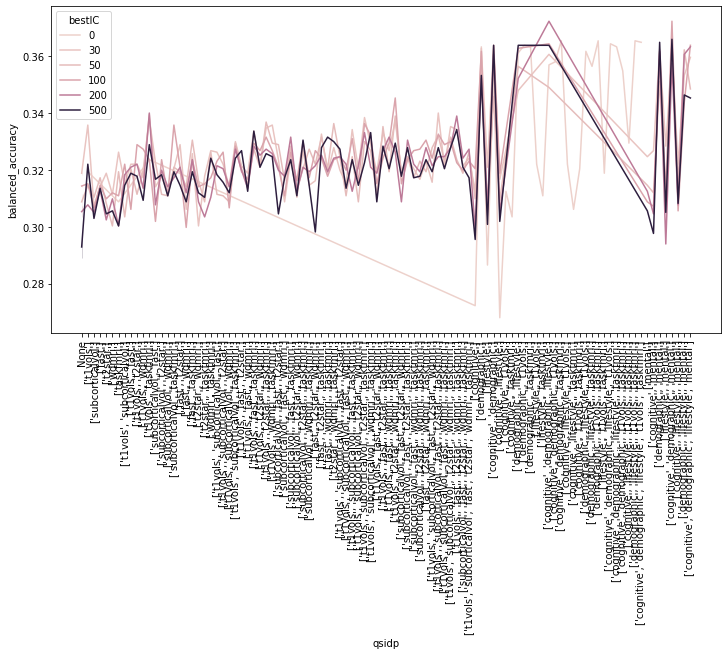

In [15]:
df_plot = df[['balanced_accuracy', 'bestIC', 'qsidp']]
fig, ax = plt.subplots(figsize=(12, 6))
_ = sns.lineplot(data=df_plot, x='qsidp', y='balanced_accuracy', hue='bestIC', ax=ax)
_ = plt.xticks(rotation=90)

#### retrain

In [61]:
bestIC = 200
qs_ls = ['cognitive', 'demographic', 'lifestyle']
idp_ls = None

In [62]:
bp = df.iloc[df['balanced_accuracy'].argmax()].to_dict()

In [63]:
for i in ['balanced_accuracy', 'roc_auc', 'bestIC', 'qsidp', 'index']:
    del bp[i]

In [64]:
bp

{'max_depth': 4,
 'n_estimators': 125,
 'max_features': 0.6036526471380582,
 'min_samples_split': 8,
 'min_samples_leaf': 12,
 'max_samples': 0.741283441988088}

In [65]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(**bp)

In [67]:
# load bfl
df_bfl_qsidp = make_data_paintype(bestIC=bestIC, qs_ls=qs_ls, idp_ls=idp_ls)
# retrain params
X_train, y_train, X_valid, y_valid = load_feats(df_bfl_qsidp, test_size=0.25, dummies=False,
                              train=True, balance=True, scaler=True)

/gpfs3/well/seymour/users/uhu195/python/extract-py3.7.4-skylake/lib/python3.7/site-packages/ipykernel_launcher.py:2: DtypeWarning: Columns (863,867) have mixed types.Specify dtype option on import or set low_memory=False.
  


df_qs_imputed_dum shape=(2724, 74)
df_bfl_qsidp shape=(2724, 279)
(2724, 273)


In [68]:
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, max_features=0.6036526471380582,
                       max_samples=0.741283441988088, min_samples_leaf=12,
                       min_samples_split=8, n_estimators=125)

In [69]:
preds = clf.predict(X_train)
print(len(preds))
print(balanced_accuracy_score(y_train, preds))
print(sum(y_train==preds)/len(y_train))

1416
0.5402542372881356
0.5402542372881356


In [70]:
preds = clf.predict(X_valid)
print(len(preds))
print(balanced_accuracy_score(y_valid, preds))
print(sum(y_valid==preds)/len(y_valid))

472
0.375
0.375


In [71]:
roc_auc_score(y_valid, clf.predict_proba(X_valid), multi_class='ovr')

0.6105465383510486

In [72]:
df_bfl_qsidp.columns

Index([                     'eid', 'irritable bowel syndrome',
                       'migraine',                'back pain',
                 'osteoarthritis',                     'bmrc',
                                0,                          1,
                                2,                          3,
       ...
                   '6160-2.1_4.0',             '6160-2.1_5.0',
                      '21003-2.0',                '26412-0.0',
                      '20240-0.0',                '26418-0.0',
                   '6160-2.3_5.0',                '21000-2.0',
                      '26428-0.0',                '26420-0.0'],
      dtype='object', length=279)

In [73]:
output_ls = ['irritable bowel syndrome', 'back pain', 'osteoarthritis', 'migraine', 'eid', 'bmrc']
tmp = df_bfl_qsidp.drop(columns=output_ls)
feature_names = tmp.columns

In [16]:
# feature_imp = feature_importance(clf, feature_names)

In [74]:
feat_importances = pd.Series(clf.feature_importances_, index=feature_names)

In [75]:
feat_sorted = feat_importances.sort_values(ascending=False)

Text(0, 0.5, 'Mean decrease in impurity')

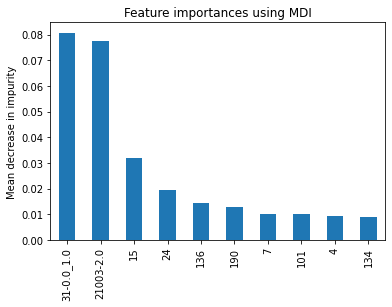

In [76]:
fig, ax = plt.subplots()
feat_sorted.iloc[:10].plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

In [77]:
feats10 = feat_sorted.iloc[:10].index
match_question(feats10)

[array(['Sex'], dtype=object),
 array(['Age when attended assessment centre'], dtype=object)]

#### visualising top feature

In [78]:
# data_dir = '/well/seymour/users/uhu195/python/pain/output_patients_500/Result_IC50/'
data_dir = '/well/seymour/users/uhu195/python/pain/output_patients_exmult_500//Result_IC200/'

In [79]:
def top_mods(data_dir, top_feat, mod_num=3, plot=True):
    """return top modalities given feature importance"""
    mod_contrib = np.load(os.path.join(data_dir, 'mod_contribution.npy')) # mod x feats
#     top_feat = int(feature_importance.index[0].split(' ')[1])
    print(f'top feature: {top_feat}')
    topIC = mod_contrib[:,top_feat]
    # load mod names
    mod_names = pd.read_csv('./sorted_feats.csv')
    plot_mod = mod_names.iloc[topIC.argsort()]
#     print(plot_mod.index.max())
    print('top modalities', plot_mod.iloc[-mod_num:])
    if plot:
        import matplotlib.pyplot as plt
        plt.subplots(figsize=(8,4))
        plt.bar(np.arange(len(topIC)), topIC[topIC.argsort()])
        plot_mod_names = plot_mod['modalities'].values
        plt.xticks(np.arange(len(plot_mod_names)), plot_mod_names, rotation=90)
    return top_feat, plot_mod.index[-mod_num:].values[::-1]

top feature: 15
top modalities    modalities
37      cope5
34      cope2
40     zstat2
44      cope1
8      zstat1


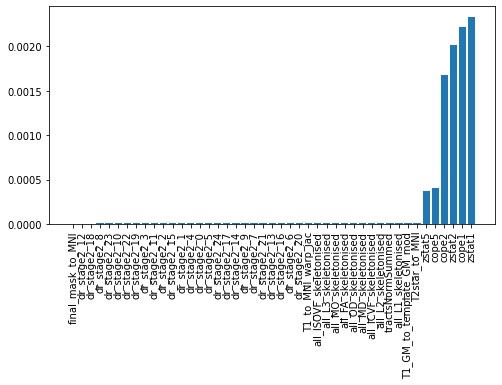

In [80]:
top_feat, mod_ls = top_mods(data_dir, top_feat=15, mod_num=5)

modality 8
(228453, 200)
modality 44
(228453, 200)
modality 40
(228453, 200)
modality 34
(228453, 200)
modality 37
(228453, 200)


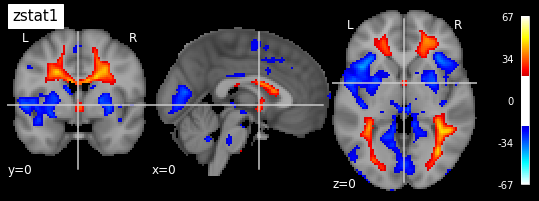

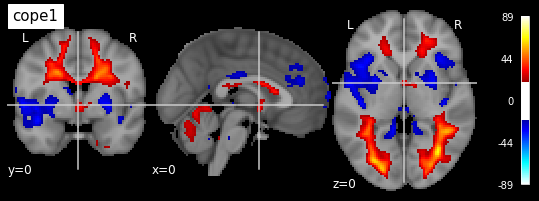

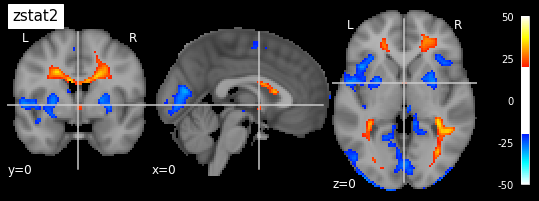

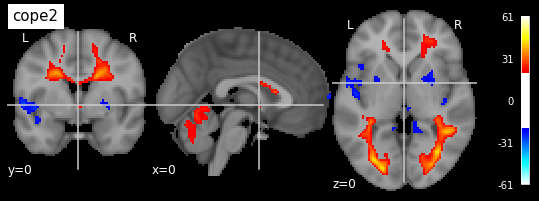

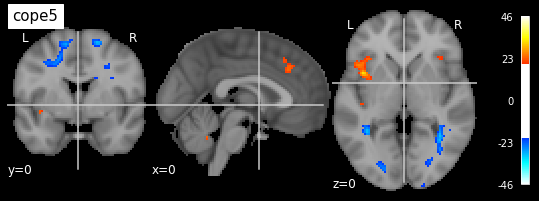

In [81]:
for mod in mod_ls:
    print(f'modality {mod}')
    reshape_z, mask_path = load_modZ(data_dir, modality_num=mod, feature_num=top_feat, plot_threshold=20)

top feature: 24
top modalities    modalities
43     zstat5
44      cope1
8      zstat1
34      cope2
40     zstat2


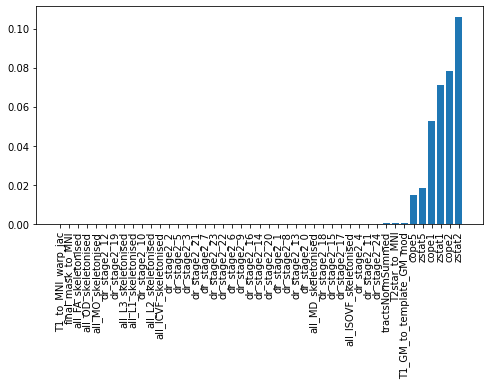

In [82]:
top_feat, mod_ls = top_mods(data_dir, top_feat=24, mod_num=5)

modality 40
(228453, 200)
modality 34
(228453, 200)
modality 8
(228453, 200)
modality 44
(228453, 200)
modality 43
(228453, 200)


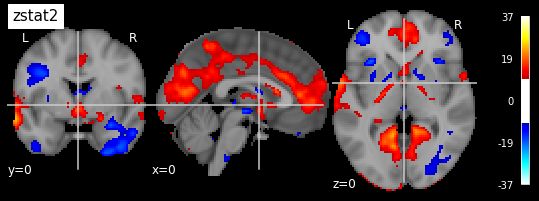

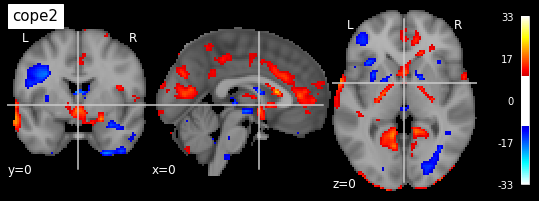

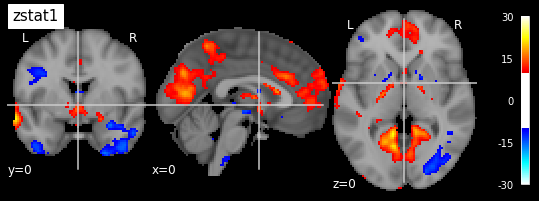

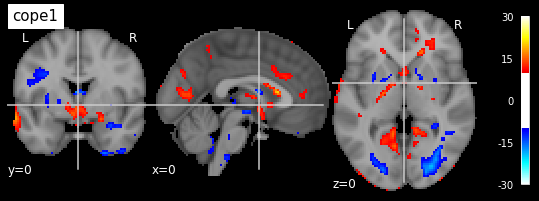

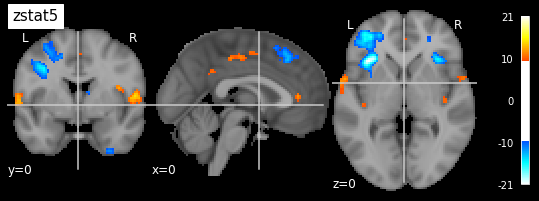

In [85]:
for mod in mod_ls:
    print(f'modality {mod}')
    reshape_z, mask_path = load_modZ(data_dir, modality_num=mod, feature_num=top_feat, plot_threshold=10)